# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [1]:
!pip install nltk

In [421]:
import warnings
warnings.filterwarnings("ignore")

In [513]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [489]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [490]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [491]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [492]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [493]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [494]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count,show=True):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    ## "line", "episode" "scene"
    for line, name, gender, episode, scene, scene_info in zip(df.Line, df.Character_name, df.Gender, df.Episode, df.Scene,df.Scene_info):
        if not name in character_docs.keys():
            character_docs[name]={}
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        if not f"({episode},{scene})" in character_docs[name]:
            character_docs[name][f"({episode},{scene})"] = {"line":"","scene_info":scene_info}
        character_docs[name][f"({episode},{scene})"]["line"] += str(line)  + " _EOL_ "
        character_line_count[name]+=1
    if show==True:
        print("lines per character", character_line_count)
    return character_docs

In [495]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    count = 0
    for i in train_character_docs[name].values():
        count += len(i["line"].split())
    print(name, 'Number of Words: ',count)
    total_words += count
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [496]:
def CaseFolder(text):
    return text.lower()

def KeepPunctuation(text):
    return text.split()

def SeparatePunctuationAndNumbers(text):
    # return re.findall( r'\w+|[^\s\w]+', text)
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    return text.split()
    
def SeparateSentenceEnderPunctuation(text):
    text = text.replace("...", " || ")
    
    pattern_punc_1 = "[^a-zA-Z\?!\.|]"
    prelim_1 = re.split(pattern_punc_1, text)
    # now on each token split word from punc
    pattern_punc_2 = "(?<=)(?=[!\.\?])"
    prelim_2 = []
    for token in prelim_1:
        prelim_2.extend(re.split(pattern_punc_2, token))
    pattern_punc_3 = "(?<=[!\.\?])(?=)"
    tokens = []
    for token in prelim_2:
        tokens.extend(re.split(pattern_punc_3, token))
    return ["..." if token=="||" else token for token in tokens]

def RemoveAllPunctuation(text):   #### Needs to be default
    return re.split("\W", text)

stopword_list = nltk.corpus.stopwords.words('english')
    
def StopwordRemover(tokens, lexicon=stopword_list):
    return [token for token in tokens if token not in stopword_list]

from nltk.stem import WordNetLemmatizer
wnl= WordNetLemmatizer()

def Lemmatizer(tokens, lemmatizer = wnl):    
    return [lemmatizer.lemmatize(token) for token in tokens]

In [497]:
pre_processing_switches = {
    "case_folding" : True,
    "keep_punctuation":False,
    "separate_punctuation":False,
    "sentence_ender_punctuation":False,
    "stopword_removal" : True,
    "lemmatization" : True,
}

In [498]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    ## Case Folding
    if pre_processing_switches["case_folding"] == True:
        character_text = CaseFolder(character_text)
    
    ## Tokenization
    if pre_processing_switches["sentence_ender_punctuation"] == True:
        tokens = SeparateSentenceEnderPunctuation(character_text)
    elif pre_processing_switches["keep_punctuation"] == True:
        tokens = KeepPunctuation(character_text)
    elif pre_processing_switches["separate_punctuation"] == True:
        tokens = SeparatePunctuationAndNumbers(character_text)
    else:
        tokens = RemoveAllPunctuation(character_text)
    
    ## Stopword Removal
    if pre_processing_switches["stopword_removal"] == True:
        tokens = StopwordRemover(tokens)
    
    ## Lemmatization
    if pre_processing_switches["lemmatization"] == True:
        tokens = Lemmatizer(tokens)
        
    
    ## Remove "" #### For All
    while "" in tokens:
        tokens.remove("")
    
    return tokens

In [499]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
train_labels = [name for name, doc,scene_info in training_corpus]

In [500]:
def nGram(doc, n=[1]):
    if type(n)!= list:
        n = list(n)
    n = [1] + n
    n = [int(i) for i in n]
    eol_list = ["_EOL_", "_eol_", "EOL", "eol"]
    punctuation_list = [".", "...", "?", "!"]
    pat = ""
    for eol in eol_list:
        if eol in doc:
            pat = eol
            break
    if pat == "":
        return doc
    ngrams=[]
    n.sort()
    
    words_without_punctuation = [i for i in doc if not(i in punctuation_list)]
    words_without_punctuation = " ".join(words_without_punctuation)
    words_without_punctuation = words_without_punctuation.split(pat)
    words_without_punctuation = [i for i in words_without_punctuation if not (i in ["", " "])]
    start = []
    end = []
    for i in range(len(n)):
        if n[i] == 1:
            continue
        for v in range(n[i] - n[i-1]):
            start.append("<eol>")
            end.append("</eol>")
        for words in words_without_punctuation:
            text = start + words.strip().split(" ") + end
            for j in range(len(text) - n[i] +1):
                ngrams.append(" ".join(text[j:j+n[i]]))
    return ngrams

import csv
def SentimentLexiconFromFile(filename="sentiment_lexicon.csv"):
    positive_sentiment = []
    negative_sentiment = []
    with open(filename) as file:
        for i in csv.reader(file):
            if i[0] == "positive":
                positive_sentiment.append(i[1].lower())
            elif i[0] == "negative":
                negative_sentiment.append(i[1].lower())
    return [negative_sentiment, positive_sentiment]

negative_lexicon,positive_lexicon = SentimentLexiconFromFile()

def getSentiment(tokens, negative_lexicon=negative_lexicon,positive_lexicon=positive_lexicon):
    sentiment = {"positive_sentiment":0, "negative_sentiment":0}
    for token in tokens:
        if token in negative_lexicon:
            sentiment["negative_sentiment"]+=1
        elif token in positive_lexicon:
            sentiment["positive_sentiment"]+=1
    return sentiment

def UpperLowerRatio(tokens):
    upper_count = 0
    lower_count = 0
    for i in tokens:
        if i[0].isupper()==True:
            upper_count += 1
        if i[0].islower()==True:
            lower_count += 1
    return {"upper_count":upper_count, "lower_count":lower_count}

def AWL(word_counts):
    awl_tokens = 0
    awl_types = 0
    c_tokens = sum(word_counts.values())
    c_types = len(word_counts)
    word_length_tokens = 0
    word_length_types = 0
    for key in list(word_counts.keys()):
        word_length_tokens += len(key) * word_counts[key]
        word_length_types += len(key)
    awl_tokens = word_length_tokens / c_tokens
    awl_types = word_length_types / c_types
    return {"awl_tokens":awl_tokens, "awl_types":awl_types}

def UniqueWordsPerTotalWords(word_counts):
    return sum(word_counts.values())/len(word_counts)

def PunctuationFrequency(counts):
    punctuation_list = [".", ",", "?", ";", "!", ":",
                        "'", "(", ")", "[", "]", "\"",
                       "...", "-", "/", "@", "{", "}", "*"]
    punctuation_count = 0
    for count in punctuation_list:
        punctuation_count += 1
    return punctuation_count

from nltk.corpus import brown,treebank
##print(len(brown.tagged_words()))
##print(len(treebank.tagged_words()))
#### gonna use brown.tagged_words() - it has more words

brown_tagged = brown.tagged_sents()
zero_tagger = nltk.DefaultTagger("NN")
unigram_tagger = nltk.UnigramTagger(brown_tagged, backoff=zero_tagger)
bigram_tagger= nltk.BigramTagger(brown_tagged, backoff=unigram_tagger)
trigram_tagger = nltk.TrigramTagger(brown_tagged, backoff=bigram_tagger)

from collections import defaultdict

### pos_tagger ensures that we only do bigram and trigram tag on lines
###  rather than just the entire speech for that person

def PosTagger(words, gram=1):
    tagged = Counter()
    if not(gram in [1,2,3]):
        return {}
    elif gram == 1:
        sentences = (" ".join(words)).split()
        return dict(Counter(unigram_tagger.tag(sentences)))
    elif gram == 2:
        for sentences in words:
            sentence = sentences.split()
            tagged += Counter(bigram_tagger.tag(sentence))
    elif gram == 3:
        for sentences in words:
            sentence = sentences.split()
            tagged += Counter(trigram_tagger.tag(sentence))
        
    return dict(tagged)

def PosTaggerExtractor(words, gram=1):
    only_tags = {}
    tagged = PosTagger(words, gram)
    for k,v in tagged.items():
        only_tags.setdefault(k[1],0)
        only_tags[k[1]] += v
    return only_tags


In [501]:
feature_extraction_switches = {"n_grams":[5], "get_sentiment":False, "pos_tagger":False,
                               "lower_upper_ratio":False, "awl":False, "unique_words_per_total_words":False,
                               "punctuation_frequency":False, "incorrect_spelling_frequency":False}

In [502]:
default_feature_extraction_switches = {"n_grams":False, "get_sentiment":False, "pos_tagger":False,
                               "lower_upper_ratio":False, "awl":False, "unique_words_per_total_words":False,
                               "punctuation_frequency":False, "incorrect_spelling_frequency":False,}

def to_feature_vector_dictionary(character_doc,extra_features = default_feature_extraction_switches):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    extra_features_values = {}
    
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    ## A list of potential non-words that will be omitted for some feature extraction.
    non_word_list = ["_EOL_", "_eol_", "EOL", "eol", ".", ",", "?", ";", "!", ":",
                     "'", "(", ")", "[", "]", "\"", "...", "-", "/", "@", "{", "}", "*"]
    punctuation_list = [".", ",", "?", ";", "!", ":", "'", "(", ")", "[", "]", "\"", "...", "-", "/", "@", "{", "}", "*"]
    eol_list = ["_EOL_", "_eol_", "EOL", "eol"]
    ### This next part get the words in a canonical form for the pos tagger. It gets it in a form s.t. we remove all punctuation
    ###  and we use the EOLs as a delimitter between utterences. This ensures that we don't get the incorrect context (I.e.,
    ###  context spanning across utterences).
    pat = ""
    for eol in eol_list:
        if eol in character_doc:
            pat = eol
            break
    if pat != "":
        remove_punctuation = [i for i in character_doc if not(i in punctuation_list)]
        remove_punctuation = " ".join(remove_punctuation)
        remove_punctuation = remove_punctuation.split(pat)
        while " " in remove_punctuation:
            remove_punctuation.remove(" ")
        word_no_punc = remove_punctuation
    
    
    word_counts = {k:v for k,v in counts.items() if not(k in non_word_list)}

    
    if extra_features["n_grams"] != False:
        ngrams = nGram(character_doc, extra_features["n_grams"])
        extra_features_values["n_grams"] = dict(Counter(ngrams))
        
    if extra_features["pos_tagger"] != False:
        extra_features_values["pos_tagger"] = PosTaggerExtractor(word_no_punc, extra_features["pos_tagger"])
    
    if extra_features["get_sentiment"] == True:
        extra_features_values["get_sentiment"] = getSentiment(character_doc)
    
    if extra_features["lower_upper_ratio"] == True:
        extra_features_values["lower_upper_ratio"] = UpperLowerRatio(word_counts)
    
    if extra_features["awl"] == True:
        extra_features_values["awl"] = AWL(word_counts)
        
    if extra_features["unique_words_per_total_words"] == True:
        extra_features_values["unique_words_per_total_words"] = UniqueWordsPerTotalWords(word_counts)
        
    if extra_features["punctuation_frequency"] == True:
        extra_features_values["punctuation_frequency"] = PunctuationFrequency(word_counts)
    
        
    ### This one could be quite hard since I don't know the theory
    # if extra_features["incorrect_spelling_frequency"]:
        
    
    # add the extra features, for now just adding one count for each extra feature
    for key,value in extra_features.items():
        if value == False:
            continue
        val = extra_features_values[key]
        if type(val) == dict:
            counts.update(**val)
        else:
            counts[key] = val
    
    return counts  

In [503]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
tfidf = TfidfTransformer()

pipeline = Pipeline([("count", DictVectorizer()),
                    ("tfidf", TfidfTransformer())])
####

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False,SelectKBestModel=SelectKBest(mutual_info_classif, k="all"),feature_extraction_switches=feature_extraction_switches,q5=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    
    
    
    (name, parsed lines, scene_info)
    """
    
    
    new_corpus = {}
    scenes = {}
    for person,docs,scene_info in corpus:
        scenes[person] = []
        val = [j for i in scene_info for j in i.split()]
        for scene,doc in docs.items():
            scenes[person].append(scene)
            val.extend(doc)
        new_corpus[person] = val
    
    for person,scc in scenes.items():
        extra_info = []
        for scene in scc:
            for i in scenes.keys():
                if scene in scenes[i] and person != i:
                    for j in range(len(corpus)):
                        if corpus[j][0] == i:
                            extra_info.extend(corpus[j][1][scene])
        new_corpus[person].extend(extra_info)
    new_corpus = tuple(new_corpus.items())
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        fit_names = []
        fit_docs = []
        for name, doc in new_corpus:
            fit_names.append(name)
            fit_docs.append(to_feature_vector_dictionary(doc, feature_extraction_switches))
            
        if q5 == True:
            doc_feature_matrix = pipeline.fit_transform(fit_docs)
        else:
            doc_feature_matrix = corpusVectorizer.fit_transform(fit_docs)
        if (SelectKBestModel.get_params()["k"] != "all" and doc_feature_matrix.shape[1] <= SelectKBestModel.get_params()["k"]):
            SelectKBestModel.set_params(**{"k":"all"})
        doc_feature_matrix = SelectKBestModel.fit_transform(doc_feature_matrix, fit_names)
    else:
        if q5==True:
            doc_feature_matrix = pipeline.transform([to_feature_vector_dictionary(doc,feature_extraction_switches) for name,doc in new_corpus])
        else:
            doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, feature_extraction_switches) for name, doc in new_corpus])
        doc_feature_matrix = SelectKBestModel.transform(doc_feature_matrix)
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix


#### Choose K=2500
select_k_best_model = SelectKBest(mutual_info_classif, k=2500)

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, SelectKBestModel=select_k_best_model, q5=True)

In [504]:
training_feature_matrix

<16x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 23141 stored elements in Compressed Sparse Row format>

In [505]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    count = 0
    for i in val_character_docs[name].values():
        count += len(i["line"].split())
    print(name, 'Number of Words: ',count)
    total_words += count
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
val_labels = [name for name, doc,scene_info in training_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Number of Words:  438
MAX Number of Words:  737
SEAN Number of Words:  366
SHIRLEY Number of Words:  329
OTHER Number of Words:  357
STACEY Number of Words:  412
RONNIE Number of Words:  464
JACK Number of Words:  351
PHIL Number of Words:  475
IAN Number of Words:  508
JANE Number of Words:  458
ROXY Number of Words:  392
HEATHER Number of Words:  411
MINTY Number of Words:  470
CHRISTIAN Number of Words:  489
CLARE Number of Words:  405
total words 7062


In [506]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False,SelectKBestModel=select_k_best_model, q5=True)

In [507]:
val_feature_matrix

<16x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 4577 stored elements in Compressed Sparse Row format>

In [508]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [509]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels,show=True):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    if show == True:
        print("mean rank", np.mean(rankings))
        print("mean cosine similarity", mean_cosine_similarity)
        print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [510]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [511]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.125
mean cosine similarity 0.940359748695311
8 correct out of 16 / accuracy: 0.5


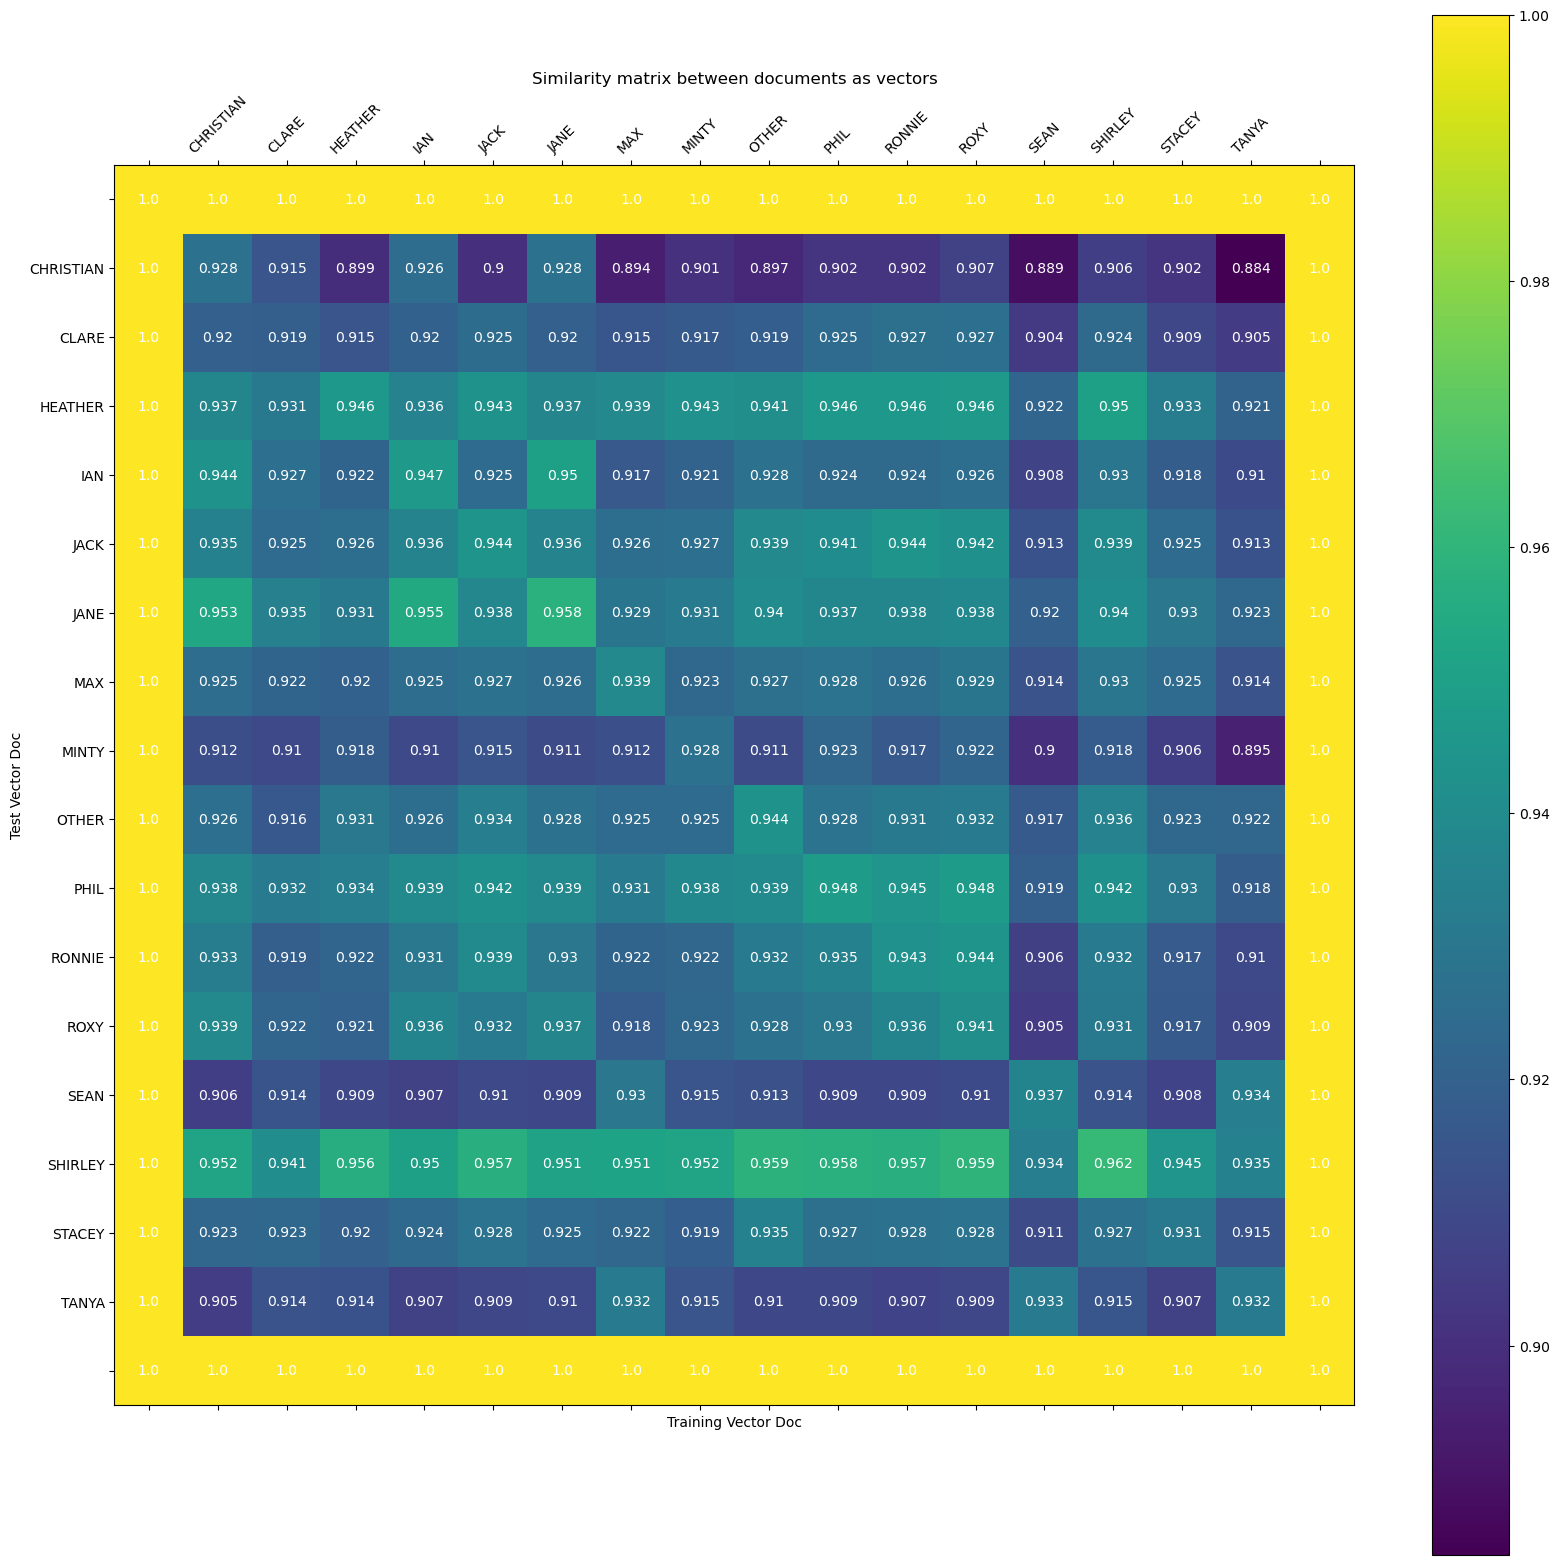

In [512]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set and a mean rank of **4.5** and accuracy of **0.25** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (20 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

You could use feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Analyse the similarity results (10 marks)
From your system so far run on the 90%/10% training/validation split, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

# Q4. Add dialogue context and scene features (20 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. You can also use **scene_info** column to extract information about the scene **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

In [334]:
## Note I have modified the create_character_document_from_dataframe as needed

In [514]:
feature_extraction_switches = {"get_sentiment":False, "lower_upper_ratio":False, "awl":False,
                               "unique_words_per_total_words":False,"punctuation_frequency":False,
                               "n_grams":False, "pos_tagger":False}
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}

result = {"k":"all","combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
result["combinations"] = feature_extraction_switches.copy()
training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
train_labels = [name for name, doc,scene_info in training_corpus]

corpusVectorizer = DictVectorizer()

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,q5=False)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
val_labels = [name for name, doc,scene_info in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches,q5=False)
result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=True)
print()

mean rank 2.0625
mean cosine similarity 0.9667236653455181
10 correct out of 16 / accuracy: 0.625



# Q5. Improve the vectorization method (20 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

In [515]:
feature_extraction_switches = {"get_sentiment":False, "lower_upper_ratio":False, "awl":False,
                               "unique_words_per_total_words":False,"punctuation_frequency":False,
                               "n_grams":False, "pos_tagger":False}
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}

result = {"k":"all","combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
result["combinations"] = feature_extraction_switches.copy()
training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
train_labels = [name for name, doc,scene_info in training_corpus]

pipeline = Pipeline([("count", DictVectorizer()),("tfidf", TfidfTransformer())])

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,q5=True)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
val_labels = [name for name, doc,scene_info in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches,q5=True)
result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=True)
print()

mean rank 1.9375
mean cosine similarity 0.9390773371244145
8 correct out of 16 / accuracy: 0.5



In [516]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s,r) for r in range(len(s)+1))

In [528]:
## Interstingly, this doesn't perform too well.
## This could be due to hyperparameter tuning on the TfidfTransformer

feature_extraction_switches = {"get_sentiment":False, "lower_upper_ratio":False, "awl":False,
                               "unique_words_per_total_words":False,"punctuation_frequency":False,
                               "n_grams":False, "pos_tagger":False}
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}

combos = list(powerset(["use_idf","smooth_idf","sublinear_tf"]))
norms = [None, "l1", "l2"]
results = []
count=0

for combo in combos:
    for normm in norms:
        print(count)
        count+=1
        result = {"combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
        result["combinations"] = {"norm":normm, "use_idf":False, "smooth_idf":False, "sublinear_tf":False}
        for val in combo:
            result["combinations"][val] = True
        training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
        train_labels = [name for name, doc,scene_info in training_corpus]

        pipeline = Pipeline([("count", DictVectorizer()),("tfidf", TfidfTransformer(norm=normm, use_idf=result["combinations"]["use_idf"], smooth_idf=result["combinations"]["smooth_idf"], sublinear_tf=result["combinations"]["sublinear_tf"]))])

        training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,q5=True)
        val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
        val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
        val_labels = [name for name, doc,scene_info in val_corpus]
        val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches,q5=True)
        result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=False)
        results.append(result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


,norm,use_idf,smooth_idf,sublinear_tf,mean rank,mean cosine similarity,accuracy
0,l2,True,True,True,1.3750,0.378406,0.7500
1,None,True,True,True,1.3750,0.378406,0.7500
2,l1,True,True,True,1.3750,0.378406,0.7500
3,l2,True,False,True,1.3750,0.355049,0.7500
4,None,True,False,True,1.3750,0.355049,0.7500
5,l1,True,False,True,1.3750,0.355049,0.7500
6,None,False,False,True,1.5625,0.554310,0.6875
7,l1,False,False,True,1.5625,0.554310,0.6875
8,l2,False,False,True,1.5625,0.554310,0.6875
9,None,False,True,True,1.5625,0.554310,0.6875


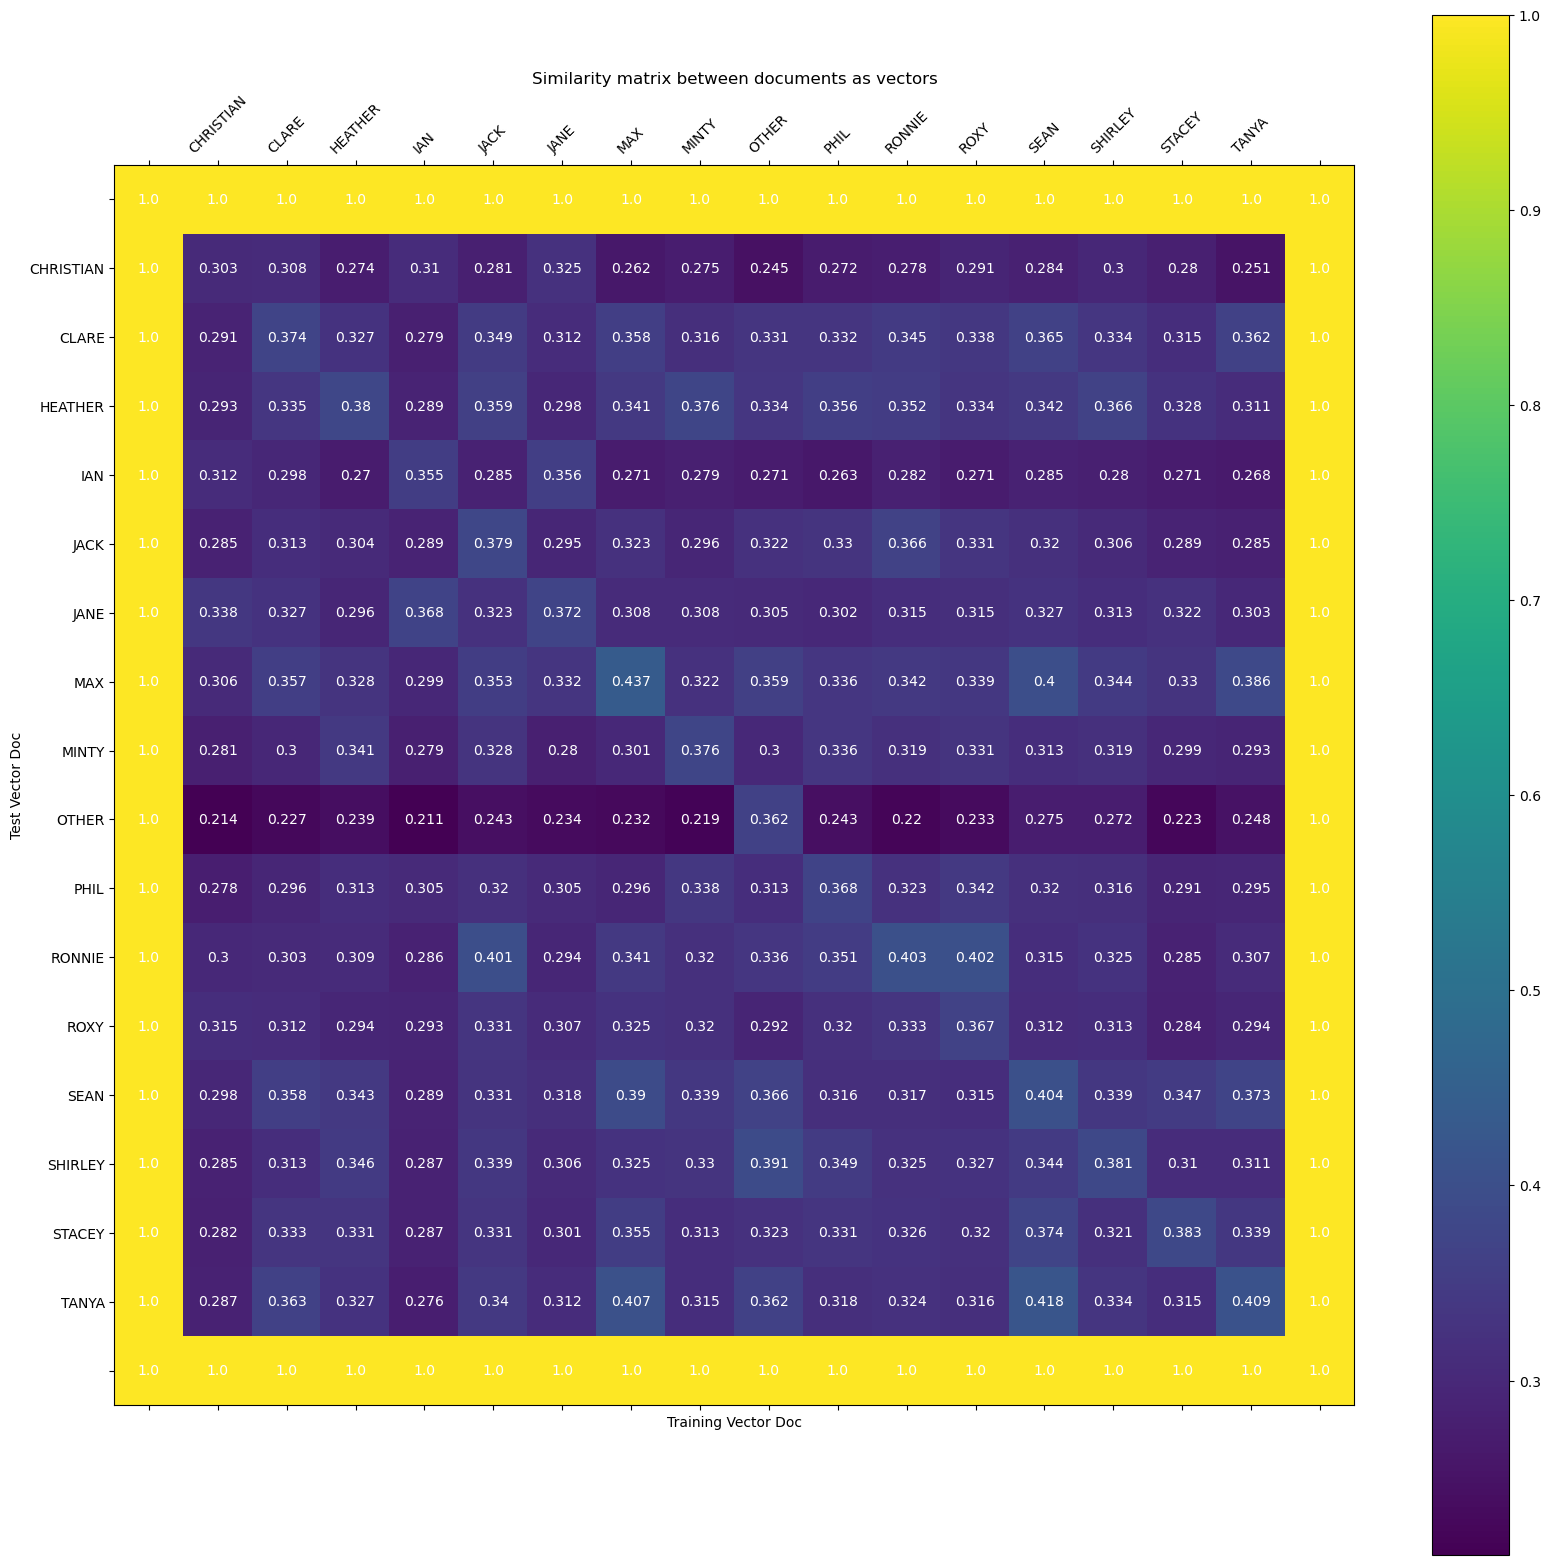

In [530]:
results = sorted(results, key=lambda x:(x["mean_rank"],x["accuracy"],-x["mean_cosine_similarity"]))
df2 = pd.DataFrame([dict((*i["combinations"].items(),("mean rank",i["mean_rank"]),("mean cosine similarity",i["mean_cosine_similarity"]),("accuracy",i["accuracy"]))) for i in results])#, columns=[*pre_processing_switches.keys(), "mean rank", "mean cosine similarity", "accuracy"])
display(df2)
plot_heat_map_similarity(results[0]["df"])
df2.to_csv("figures/q5_table1.csv")

In [531]:
### Run with these hyperparameters 
tfi_idf_hyp = {"norm":"l2", "use_idf":True, "smooth_idf":True, "sublinear_tf":True}

In [532]:
feature_hp = hyp[hyp["mean rank"] == 1.9375][["get_sentiment","lower_upper_ratio","awl","unique_words_per_total_words",
                                "punctuation_frequency", "n_grams", "pos_tagger", "k"]]

In [335]:
# I have changed the vectorization method as needed. Now, I will run everything together to try and fit as best as possible

In [447]:
## I will use the few best performing hyperparameters from the previous notebook (namley, "q13_q2_FX2.csv")
## Notice that for multiple results have a mean rank of 1.9375 and some have a very high accracy.

hyp = pd.read_csv("q13_q2_FX2.csv")
# hyp = pd.read_csv("figures/q13_q2_FX2.csv")
hyp.head(40)

,Unnamed: 0,get_sentiment,lower_upper_ratio,awl,unique_words_per_total_words,punctuation_frequency,n_grams,pos_tagger,k,mean rank,mean cosine similarity,accuracy
0,0,False,False,False,False,False,[5],False,2500,1.9375,0.929622,0.6875
1,1,False,False,False,False,True,[5],False,2500,1.9375,0.929622,0.6875
2,2,False,False,False,False,False,[5],False,2750,1.9375,0.928902,0.6875
3,3,False,False,False,False,True,[5],False,2750,1.9375,0.928902,0.6875
4,4,False,False,False,True,False,[5],False,2750,1.9375,0.928685,0.6875
5,5,False,False,False,True,True,[5],False,2750,1.9375,0.928685,0.6875
6,6,False,False,False,False,False,[5],False,3000,1.9375,0.928216,0.6875
7,7,False,False,False,False,True,[5],False,3000,1.9375,0.928216,0.6875
8,8,False,False,False,True,False,[5],False,3000,1.9375,0.927970,0.6875
9,9,False,False,False,True,True,[5],False,3000,1.9375,0.927970,0.6875


In [452]:
feature_hp = hyp[hyp["mean rank"] == 1.9375][["get_sentiment","lower_upper_ratio","awl","unique_words_per_total_words",
                                "punctuation_frequency", "n_grams", "pos_tagger", "k"]]

In [453]:
import json
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}
feature_extraction_switches_f = []
select_ks = []
for i in range(feature_hp.shape[0]):
    val = dict(feature_hp.iloc[i][["get_sentiment","lower_upper_ratio", "awl",
                                          "unique_words_per_total_words", "punctuation_frequency",
                                          "n_grams", "pos_tagger"]])
    val["n_grams"] = json.loads(val["n_grams"])
    feature_extraction_switches_f.append(val)
    
    select_ks.append(dict(feature_hp.iloc[i][["k"]])["k"])
    

In [454]:
values = []
count=0

if True:
    for i in range(len(select_ks)):
        print(count)
        count += 1
        feature_extraction_switches = feature_extraction_switches_f[i]
        select_k_model = SelectKBest(mutual_info_classif, k=select_ks[i])
        result = {"k":select_ks[i],"combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
        result["combinations"] = feature_extraction_switches.copy()
        training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
        train_labels = [name for name, doc,scene_info in training_corpus]
        
        pipeline = Pipeline([("count", DictVectorizer()),("tfidf", TfidfTransformer())])
        
        training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,SelectKBestModel=select_k_model,q5=True)
        val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
        val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
        val_labels = [name for name, doc,scene_info in val_corpus]
        val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches, SelectKBestModel=select_k_model,q5=True)
        result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=False)
        values.append(result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


,get_sentiment,lower_upper_ratio,awl,unique_words_per_total_words,punctuation_frequency,n_grams,pos_tagger,k,mean rank,mean cosine similarity,accuracy
0,False,False,False,False,True,[5],False,2500,1.6875,0.922701,0.6250
1,False,False,True,False,True,[5],False,2500,1.6875,0.920325,0.6250
2,False,False,True,True,True,[5],False,2500,1.6875,0.920246,0.6250
3,False,False,False,False,True,[5],False,2250,1.7500,0.925242,0.5625
4,False,False,False,True,True,[5],False,2250,1.7500,0.925161,0.5625
5,False,False,True,False,True,[5],False,3000,1.7500,0.915496,0.6250
6,False,False,True,True,True,[5],False,3000,1.7500,0.915419,0.6250
7,False,False,False,False,True,[5],False,2750,1.8125,0.921095,0.6250
8,False,False,False,True,True,[5],False,2750,1.8125,0.921016,0.6250
9,False,False,True,False,True,[5],False,2750,1.8125,0.918732,0.6250


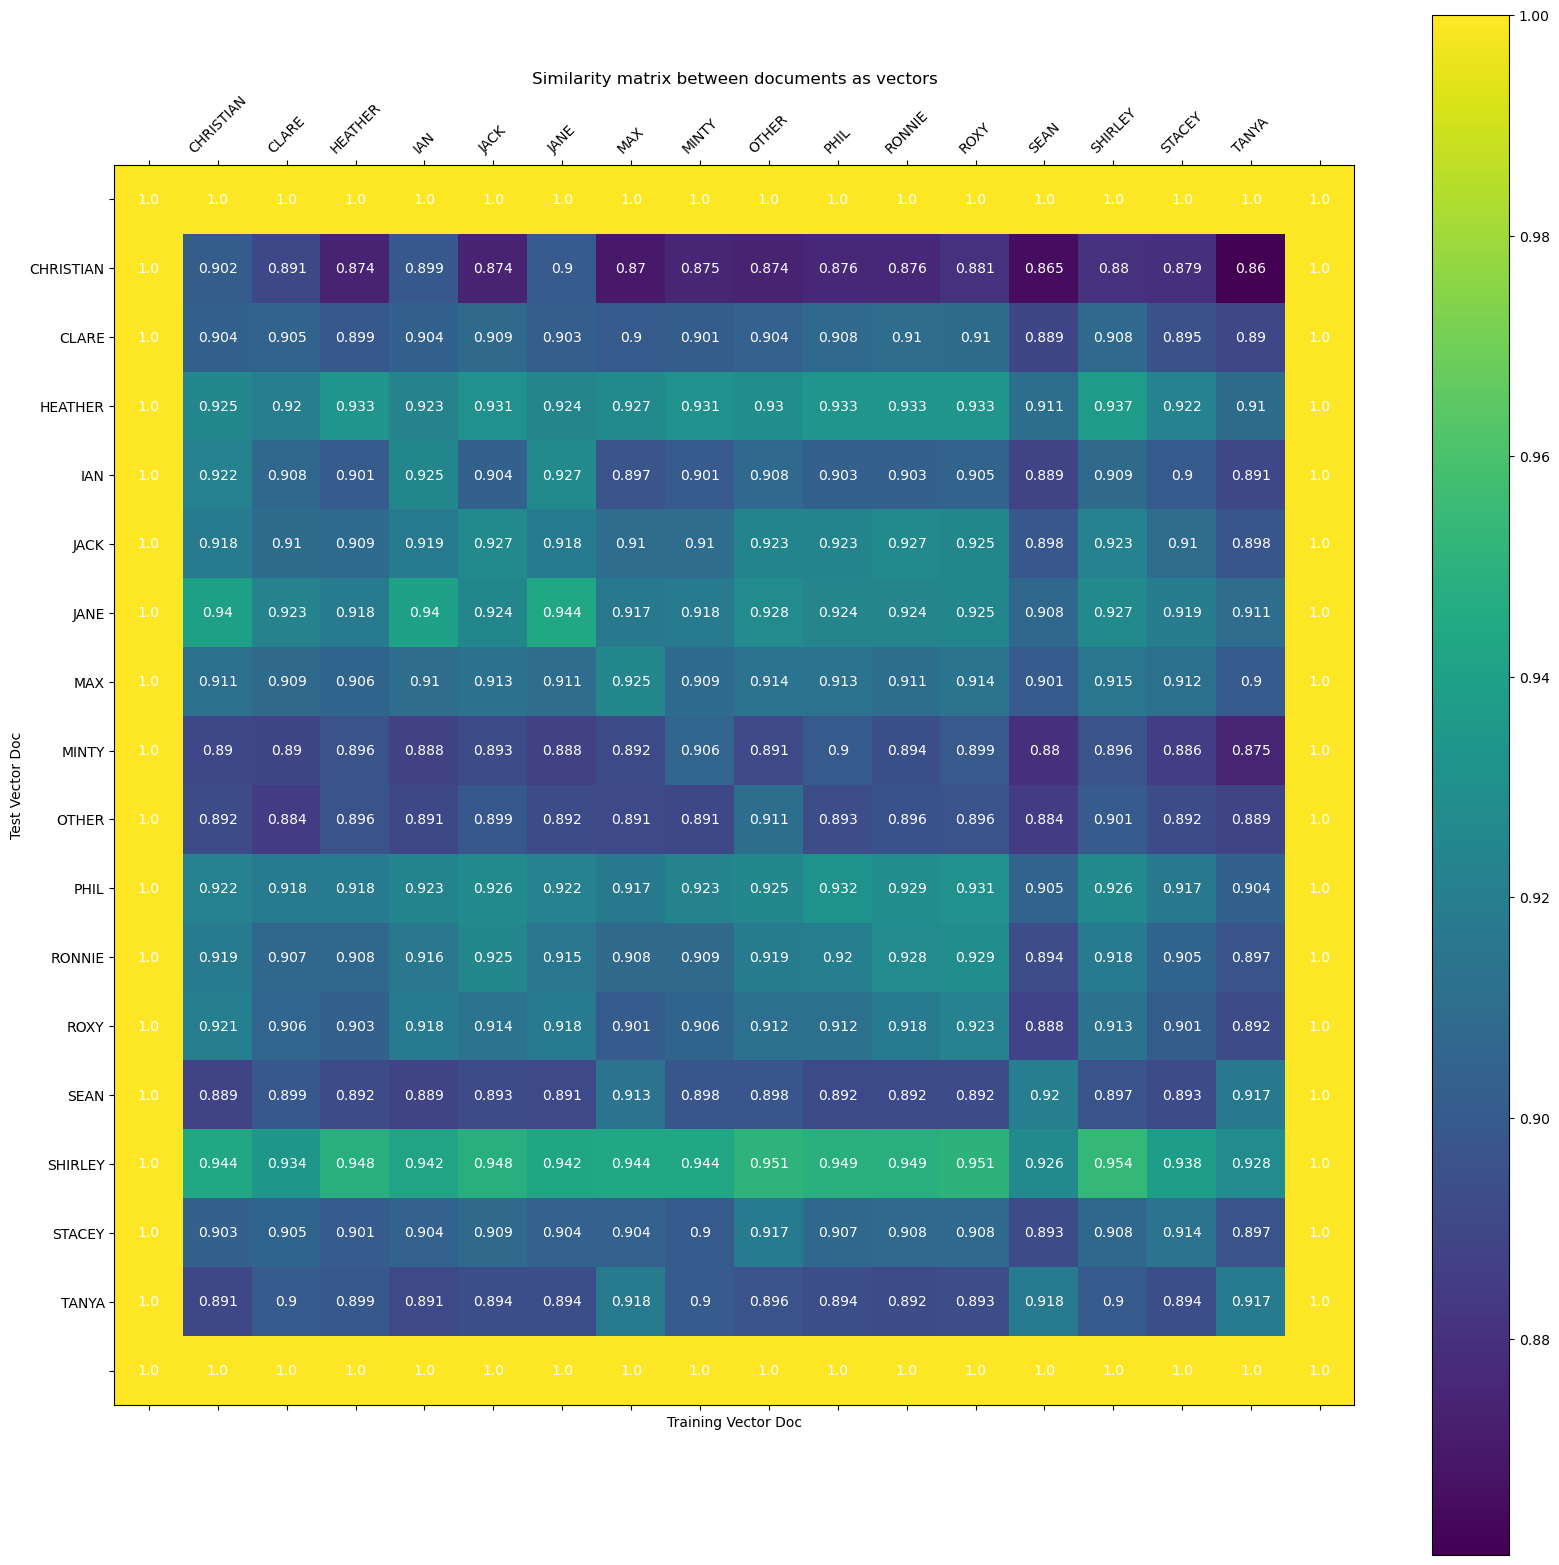

In [455]:
if True:
    results = sorted(values, key=lambda x:(x["mean_rank"],x["accuracy"],-x["mean_cosine_similarity"]))
    df = pd.DataFrame([dict((*i["combinations"].items(), ("k",i["k"]),("mean rank",i["mean_rank"]),("mean cosine similarity",i["mean_cosine_similarity"]),("accuracy",i["accuracy"]))) for i in results])#, columns=[*pre_processing_switches.keys(), "mean rank", "mean cosine similarity", "accuracy"])
    display(df)
    plot_heat_map_similarity(results[0]["df"])

In [461]:
thingyyyyy = df #### results from above

In [533]:
## Here I will run it with the hyperparameters tuned for TfiidfTransformer


pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}
feature_extraction_switches_f = []
select_ks = []
for i in range(feature_hp.shape[0]):
    val = dict(feature_hp.iloc[i][["get_sentiment","lower_upper_ratio", "awl",
                                          "unique_words_per_total_words", "punctuation_frequency",
                                          "n_grams", "pos_tagger"]])
    val["n_grams"] = json.loads(val["n_grams"])
    feature_extraction_switches_f.append(val)
    
    select_ks.append(dict(feature_hp.iloc[i][["k"]])["k"])
    

In [537]:
values = []
count=0

if True:
    for i in range(len(select_ks)):
        print(count)
        count += 1
        feature_extraction_switches = feature_extraction_switches_f[i]
        select_k_model = SelectKBest(mutual_info_classif, k=select_ks[i])
        result = {"k":select_ks[i],"combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
        result["combinations"] = feature_extraction_switches.copy()
        training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
        train_labels = [name for name, doc,scene_info in training_corpus]
        
        pipeline = Pipeline([("count", DictVectorizer()),("tfidf", TfidfTransformer(norm=tfi_idf_hyp["norm"], use_idf=tfi_idf_hyp["use_idf"], smooth_idf=tfi_idf_hyp["smooth_idf"],sublinear_tf=tfi_idf_hyp["sublinear_tf"] ))])
        
        training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,SelectKBestModel=select_k_model,q5=True)
        val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
        val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
        val_labels = [name for name, doc,scene_info in val_corpus]
        val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches, SelectKBestModel=select_k_model,q5=True)
        result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=False)
        values.append(result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


,get_sentiment,lower_upper_ratio,awl,unique_words_per_total_words,punctuation_frequency,n_grams,pos_tagger,k,mean rank,mean cosine similarity,accuracy
0,False,False,False,False,False,"[3, 4]",False,2250,1.4375,0.494239,0.7500
1,False,False,False,True,True,[5],False,2250,1.5000,0.464166,0.6875
2,False,False,False,False,True,[5],False,2250,1.5000,0.463613,0.6875
3,False,False,False,True,False,[5],False,2250,1.5000,0.462818,0.6875
4,False,False,False,False,False,[5],False,2250,1.5000,0.462261,0.6875
5,False,False,False,False,True,"[3, 4]",False,2250,1.5000,0.495148,0.7500
6,False,False,True,True,True,"[2, 3, 4]",False,2750,1.5000,0.494786,0.7500
7,False,False,True,False,True,"[2, 3, 4]",False,2750,1.5000,0.494420,0.7500
8,False,False,True,True,False,"[2, 3, 4]",False,2750,1.5000,0.494061,0.7500
9,False,False,True,False,False,"[2, 3, 4]",False,2750,1.5000,0.493686,0.7500


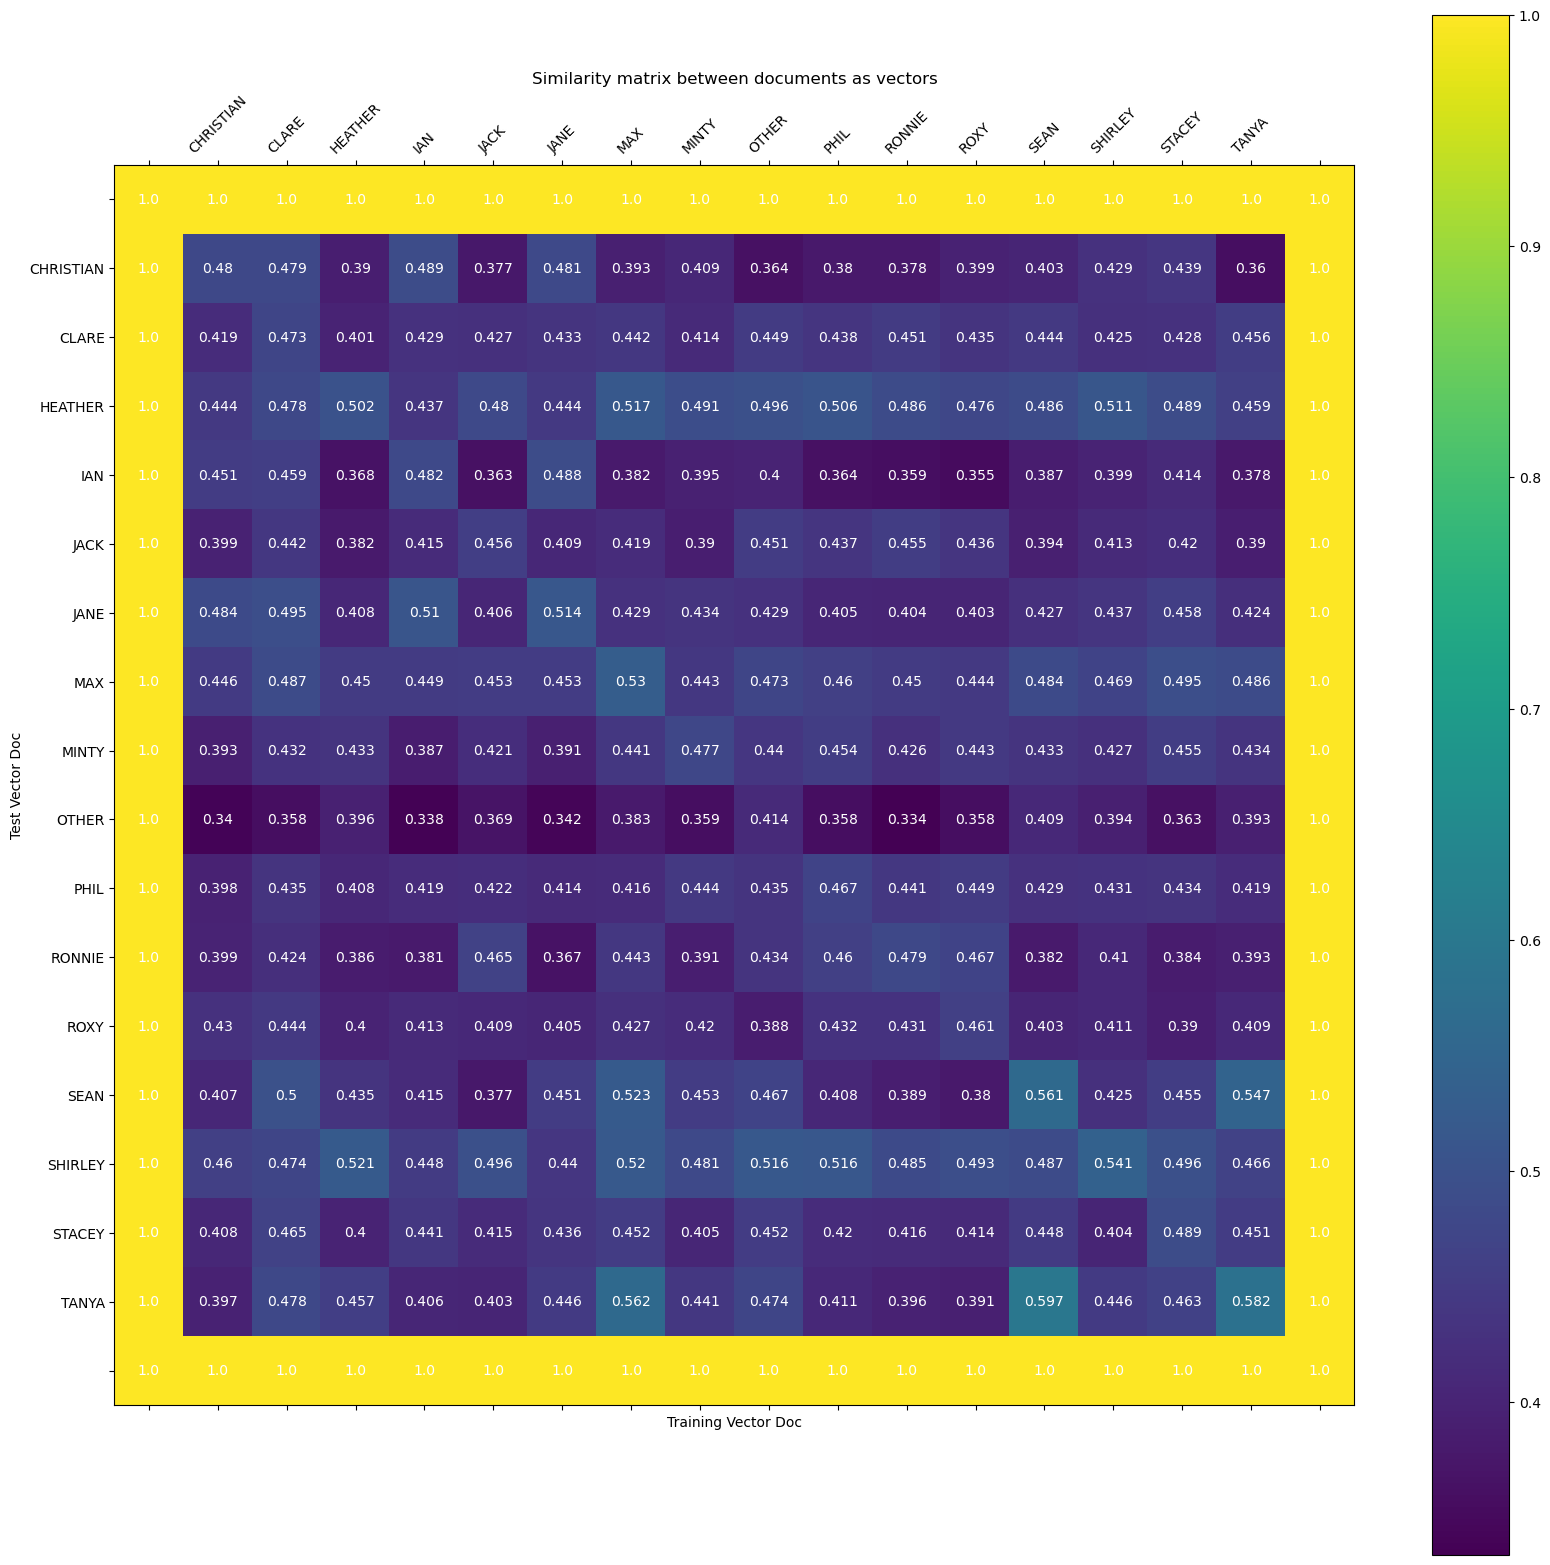

In [538]:
if True:
    results = sorted(values, key=lambda x:(x["mean_rank"],x["accuracy"],-x["mean_cosine_similarity"]))
    df = pd.DataFrame([dict((*i["combinations"].items(), ("k",i["k"]),("mean rank",i["mean_rank"]),("mean cosine similarity",i["mean_cosine_similarity"]),("accuracy",i["accuracy"]))) for i in results])#, columns=[*pre_processing_switches.keys(), "mean rank", "mean cosine similarity", "accuracy"])
    display(df)
    plot_heat_map_similarity(results[0]["df"])

In [542]:
df.to_csv("figures/q5_table2.csv")

In [545]:
### Now I will run it on the data from "q13_q2_FX3.csv", which has a higher mean ranks but also a higher accuracies than the
###  hyperparameters used above.

hyp2 = pd.read_csv("q13_q2_FX3.csv")
# hyp2 = pd.read_csv("figures/q13_q2_FX3.csv")
hyp2.head(25)

,Unnamed: 0,get_sentiment,lower_upper_ratio,awl,unique_words_per_total_words,punctuation_frequency,n_grams,pos_tagger,k,mean rank,mean cosine similarity,accuracy
0,0,False,False,False,False,False,"[2, 3]",False,2250,2.0000,0.521783,0.7500
1,1,False,False,False,False,False,"[2, 3]",False,2500,2.0000,0.517478,0.7500
2,2,False,False,False,False,False,"[2, 3]",False,2750,2.0000,0.513845,0.7500
3,3,False,False,False,False,False,"[2, 3]",False,3000,2.0000,0.511080,0.7500
4,4,False,False,False,False,False,"[2, 3, 4]",False,2750,2.0000,0.507622,0.7500
5,5,False,False,False,False,False,"[2, 3, 4]",False,3000,2.0000,0.503894,0.7500
6,6,False,False,False,False,False,"[2, 3]",False,2000,2.0625,0.527153,0.7500
7,7,False,False,False,False,False,"[2, 3, 4, 5]",False,2750,2.0625,0.505215,0.7500
8,8,False,False,False,False,False,"[2, 3, 4]",False,2250,2.1250,0.517080,0.7500
9,9,False,False,False,False,False,"[2, 3, 4]",False,2500,2.1250,0.512060,0.7500


In [548]:
feature_hp = hyp2[["get_sentiment","lower_upper_ratio","awl","unique_words_per_total_words",
                                "punctuation_frequency", "n_grams", "pos_tagger", "k"]]


In [549]:
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}
feature_extraction_switches_f = []
select_ks = []
for i in range(feature_hp.shape[0]):
    val = dict(feature_hp.iloc[i][["get_sentiment","lower_upper_ratio", "awl",
                                          "unique_words_per_total_words", "punctuation_frequency",
                                          "n_grams", "pos_tagger"]])
    val["n_grams"] = json.loads(val["n_grams"])
    feature_extraction_switches_f.append(val)
    
    select_ks.append(dict(feature_hp.iloc[i][["k"]])["k"])
    

In [ ]:
values = []
count=0

if True:
    for i in range(len(select_ks)):
        print(count)
        count += 1
        feature_extraction_switches = feature_extraction_switches_f[i]
        select_k_model = SelectKBest(mutual_info_classif, k=select_ks[i])
        result = {"k":select_ks[i],"combinations":0, "mean_rank":0, "mean_cosine_similarity":0, "accuracy":0, "df":0}
        result["combinations"] = feature_extraction_switches.copy()
        training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
        train_labels = [name for name, doc,scene_info in training_corpus]
        
        pipeline = Pipeline([("count", DictVectorizer()), ("tfidf", TfidfTransformer(norm=tfi_idf_hyp["norm"], use_idf=tfi_idf_hyp["use_idf"], smooth_idf=tfi_idf_hyp["smooth_idf"],sublinear_tf=tfi_idf_hyp["sublinear_tf"] ))])
        
        training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_extraction_switches=feature_extraction_switches,SelectKBestModel=select_k_model,q5=True)
        val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40, show=False)
        val_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(val_character_docs.items())]
        val_labels = [name for name, doc,scene_info in val_corpus]
        val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, feature_extraction_switches=feature_extraction_switches, SelectKBestModel=select_k_model,q5=True)
        result["mean_rank"], result["mean_cosine_similarity"], result["accuracy"], result["df"] = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels, show=False)
        values.append(result)

0
1
2
3
4
5


,get_sentiment,lower_upper_ratio,awl,unique_words_per_total_words,punctuation_frequency,n_grams,pos_tagger,k,mean rank,mean cosine similarity,accuracy
0,False,False,False,False,False,"[2, 3]",False,2500,1.4375,0.483695,0.6875
1,False,False,False,False,False,"[2, 3]",False,2750,1.4375,0.470650,0.6875
2,False,False,False,False,False,"[2, 3]",False,3000,1.4375,0.459247,0.6875
3,False,False,False,False,False,"[2, 3]",False,2000,1.5000,0.513658,0.6875
4,False,False,False,False,False,"[2, 3, 4, 5]",False,2750,1.5000,0.506477,0.6875
5,False,False,False,False,False,"[2, 3, 4, 5]",False,3000,1.5000,0.496464,0.6875
6,False,False,False,False,False,"[2, 3, 4]",False,2750,1.5000,0.492943,0.7500
7,False,False,False,False,False,"[2, 3, 4]",False,2250,1.5625,0.517216,0.6250
8,False,False,False,False,False,"[2, 3, 4]",False,2500,1.5625,0.503667,0.6875
9,False,False,False,False,False,"[2, 3]",False,2250,1.5625,0.499979,0.6875


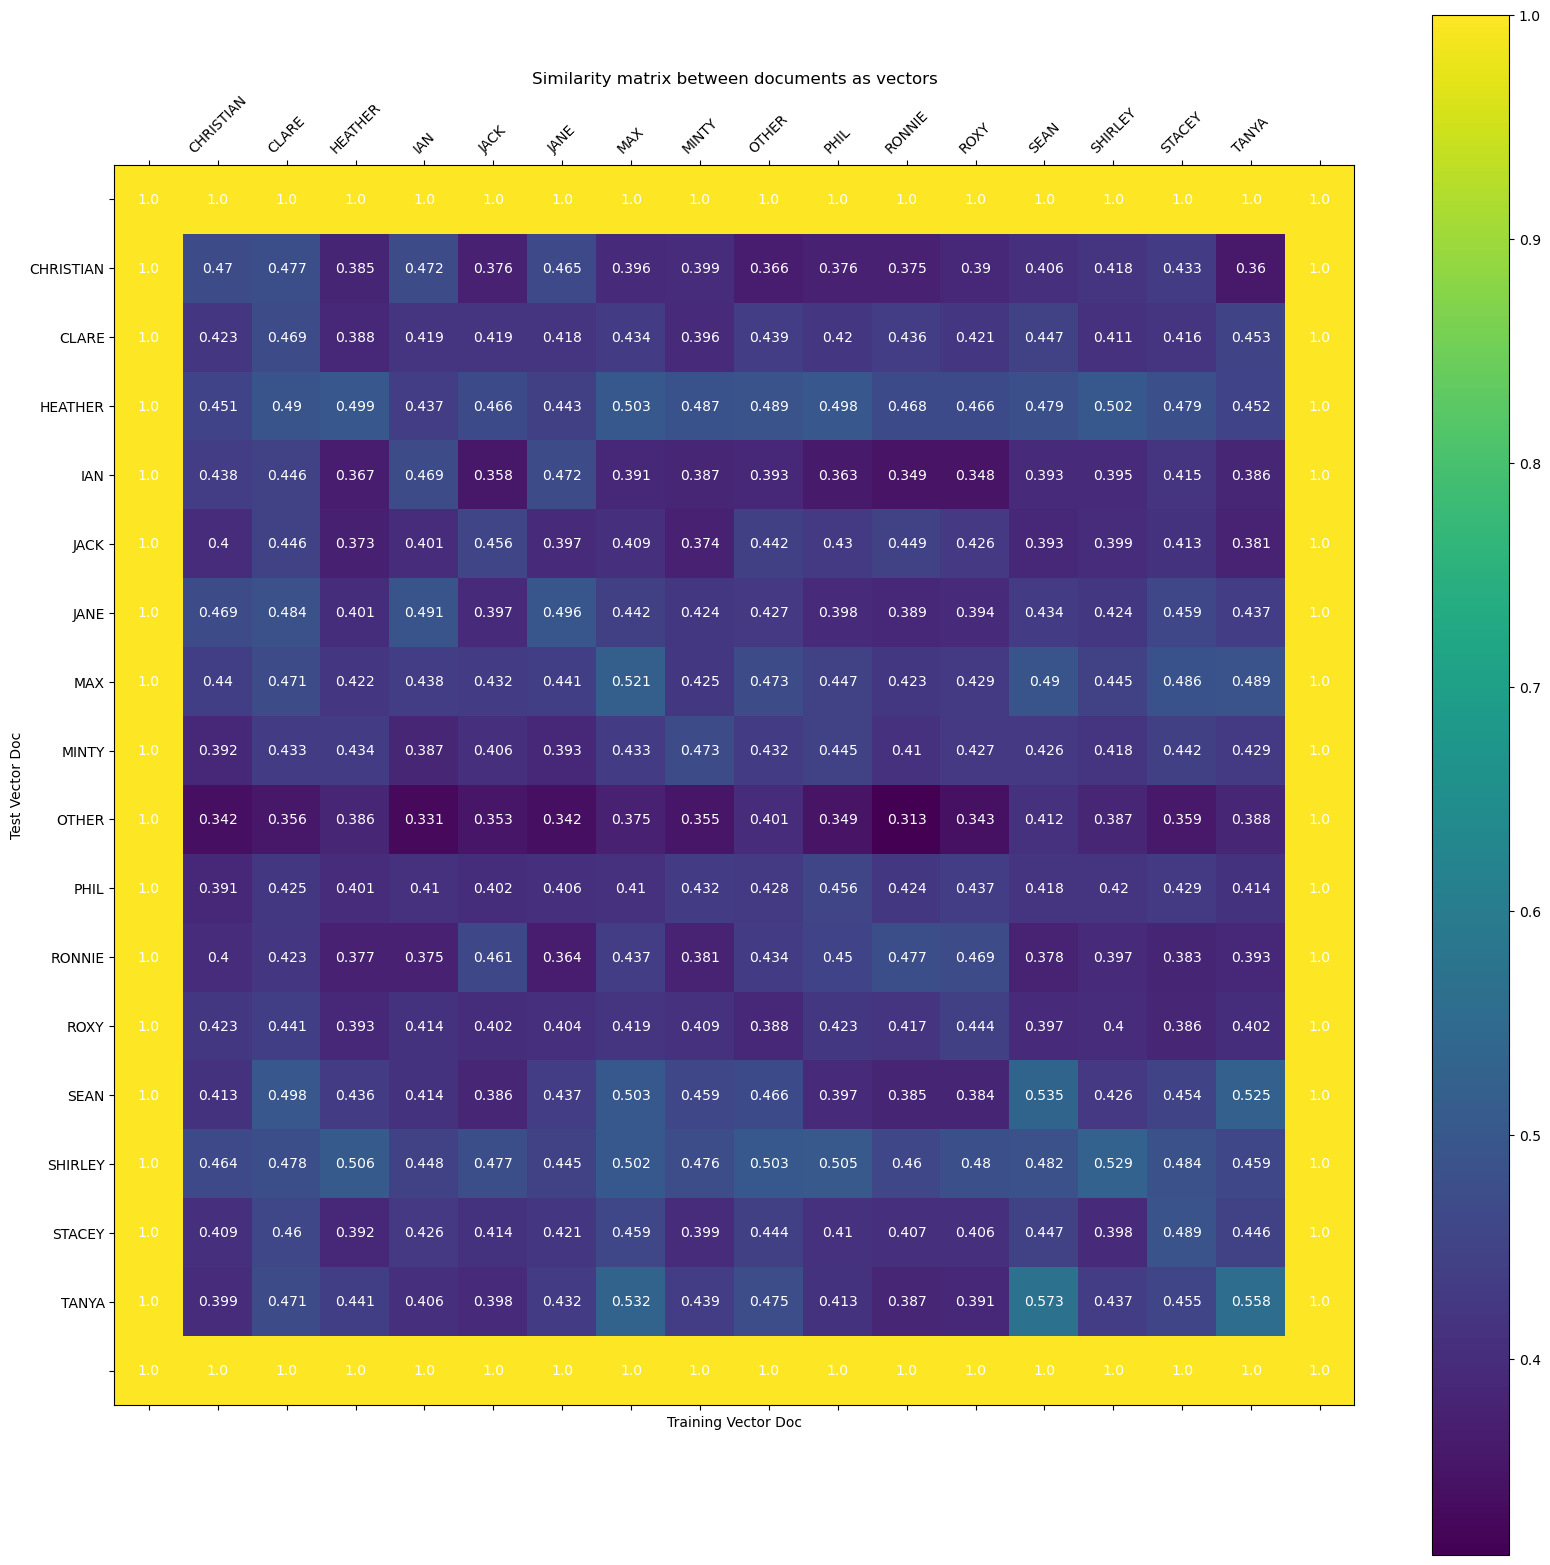

In [553]:
if True:
    results = sorted(values, key=lambda x:(x["mean_rank"],x["accuracy"],-x["mean_cosine_similarity"]))
    df = pd.DataFrame([dict((*i["combinations"].items(), ("k",i["k"]),("mean rank",i["mean_rank"]),("mean cosine similarity",i["mean_cosine_similarity"]),("accuracy",i["accuracy"]))) for i in results])#, columns=[*pre_processing_switches.keys(), "mean rank", "mean cosine similarity", "accuracy"])
    display(df)
    plot_heat_map_similarity(results[0]["df"])
    df.to_csv("figures/q5_table3.csv")

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [556]:
pre_processing_switches = {"case_folding":True, "keep_punctuation":False, "separate_punctuation":False,
                           "sentence_ender_punctuation":False, "stopword_removal":True, "lemmatization":True}
final_feature_extraction_switches = {"get_sentiment":False, "lower_upper_ratio":False, "awl":False,
                                     "unique_words_per_total_words":False, "punctuation_frequency":False,
                                     "n_grams":[3,4], "pos_tagger":False}

select_k_best_model = SelectKBest(mutual_info_classif, k=2250)

In [562]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    count = 0
    for i in train_character_docs[name].values():
        count += len(i["line"].split())
    print(name, 'Number of Words: ',count)
    total_words += count
print("total words", total_words)

training_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(train_character_docs.items())]
train_labels = [name for name, doc,scene_info in training_corpus]

# corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# pipeline = Pipeline([("count", DictVectorizer()), ("tfidf", TfidfTransformer(norm=tfi_idf_hyp["norm"], use_idf=tfi_idf_hyp["use_idf"], smooth_idf=tfi_idf_hyp["smooth_idf"],sublinear_tf=tfi_idf_hyp["sublinear_tf"] ))])

pipeline = Pipeline([("count", DictVectorizer()),("tfidf", TfidfTransformer(norm="l2", use_idf=True, smooth_idf=True,sublinear_tf=True ))])

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, SelectKBestModel=select_k_best_model, feature_extraction_switches = final_feature_extraction_switches, q5=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    count = 0
    for i in test_character_docs[name].values():
        count += len(i["line"].split())
    print(name, 'Number of Words: ',count)
    total_words += count
print("total words", total_words)

test_corpus = [(name,{k:pre_process(v["line"]) for k,v in docs.items()},[i[1]["scene_info"] for i in docs.items()])  for name, docs in sorted(test_character_docs.items())]
test_labels = [name for name, doc,scene_info in test_corpus]

# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, SelectKBestModel=select_k_best_model, feature_extraction_switches = final_feature_extraction_switches, q5=True)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  